In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
import json
file=open(r"C:\Users\Nabil\Desktop\Openclassrooms\Projet4\socrata_metadata_2015-building-energy-benchmarking.json")
meta_2015=json.load(file)
file_2=open(r"C:\Users\Nabil\Desktop\Openclassrooms\Projet4\socrata_metadata_2016-building-energy-benchmarking.json")
meta_2016=json.load(file_2)
# print(json.dumps(meta_2015, indent=4, sort_keys=True))

# <p style='text-align:center'> Fonctions </p>

In [6]:
def pie_chart(data,labels):
    colors = sns.color_palette('pastel')[0:5]
    plt.subplots(figsize=(10,10))
    plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    plt.show()

In [7]:
def graph(variable_type):
    if (variable_type=='int64_id') | (variable_type=='float64_other') | (variable_type=='Int64_zipcode') | (variable_type=='float64_location') | (variable_type=='object_other'):
        return "no graph"

    elif variable_type=='object_categorical' :
        return "pie or countplot"

    elif (variable_type=='int64_counter') | (variable_type=='Int64_counter') :
        return "histogramme"

    elif (variable_type=='int64_area')|(variable_type=='float64_area')|(variable_type=='float64_score')|(variable_type=='float64_variable') | (variable_type=='int64_year') :
        return "boxplot"
    else:
        return "not a correct variable type"

In [8]:
def variable_type(bench,variable_name):
    variable_type = str(bench[variable_name].dtype)
    if (variable_type=='int64') | (variable_type=='Int64'):
        if 'GFA' in variable_name:
            variable_type+='_area'
        else:
            int_dict={'OSEBuildingID':'_id','DataYear':'_year','CouncilDistrictCode':'_id','PropertyAge':'_year','NumberofBuildings':'_counter','NumberofFloors':'_counter','ZipCode':'_zipcode'}
            variable_type+=int_dict[variable_name]
    if variable_type=='float64':
        if 'GFA' in variable_name:
            variable_type+='_area'
        elif '(' in variable_name:
            variable_type+='_variable'
        else:    
            float_dict={'NumberofFloors':'_counter','ENERGYSTARScore':'_score',"Latitude":'_location',"Longitude":'_location',"Address":'_location',"2010 Census Tracts":'_other',"Seattle Police Department Micro Community Policing Plan Areas":'_other',"City Council Districts":'_other',"SPD Beats":'_other'}
            variable_type+=float_dict[variable_name]
    if variable_type=='object':
        if ('Type' in variable_name or variable_name=='Neighborhood')&(variable_name!='ListOfAllPropertyUseTypes'):
            variable_type+='_categorical'
        else:
            variable_type+='_other'
    return variable_type

In [9]:
def variable_exploration(bench,variables,variable_name):
    num_or_cat = "id_date" if (bench[variable_name].dtype=='int64') else "numerical" if (bench[variable_name].dtype=='float64') else "categorical"
    var_idx=(list(bench.columns)).index(variable_name)
    descriptions={}
    for i in range(len(meta_2015['columns'])):
        try:
            descriptions[meta_2015['columns'][i]['name']]=meta_2015['columns'][i]['description']
        except:
            continue
    var_graph=variables.loc[variable_name,"graph"]
    print('variable name : ',variable_name)
    try:
        print('\ndescription : ',descriptions[variable_name])
    except:
        pass
    if var_graph=='boxplot':
        if 'Year' in variable_name:
            sns.set_theme(style="whitegrid")
            ax = sns.boxplot(x=bench[variable_name])
        else:
            sns.set_theme(style="whitegrid")
            ax = sns.boxplot(x=bench[variable_name].apply(lambda x:np.log(x)))
    elif var_graph=='pie or countplot':
        n_cat = len(bench[variable_name].unique())
        if n_cat<=15:
            data=(bench[variable_name].value_counts().values)/bench.shape[0]
            labels=bench[variable_name].value_counts().index
            pie_chart(data=data,labels=labels)
        elif n_cat<=20:
            sns.set_theme(style="whitegrid") 
            ax = sns.countplot(y=variable_name, data=bench)
        else:
            print("trop de categories")
    elif var_graph=='histogramme':
        plt.subplots(figsize=(10,7))
        sns.histplot(x=list(bench[variable_name].values),log_scale=(False,True)) 

In [10]:
def complete_variable(bench,type_variable,variable_name):
    if (bench[variable_name].dtype=='float'):
        mapping_dict=(bench[[variable_name,type_variable]].groupby([type_variable]).agg(lambda x: float(np.mean(x))).to_dict())[variable_name]
    else :
        mapping_dict=(bench[[variable_name,type_variable]].groupby([type_variable]).agg(lambda x: int(np.mean(x))).to_dict())[variable_name]
    for idx in bench[bench[variable_name].isna()].index:
        bench.at[idx,variable_name]=mapping_dict[bench.at[idx,type_variable]]

In [11]:
bench16 = pd.read_csv(r"C:\Users\Nabil\Desktop\Openclassrooms\Projet4\2016-building-energy-benchmarking.csv")
bench16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

# <p style='text-align:center'> Concaténation des données de 2015 et de 2016 </p>

In [12]:
# Préparation du DataFrame benchmarking 2015 avant la concaténation
bench15 = pd.read_csv(r"C:\Users\Nabil\Desktop\Openclassrooms\Projet4\2015-building-energy-benchmarking.csv")
bench15 = bench15.rename({'Comment':'Comments','Zip Codes':'ZipCode'},axis=1)
bench15['NumberofFloors']=bench15['NumberofFloors'].astype('Int64')
bench15['Latitude']=bench15['Location'].apply(lambda r:r.split('\'')[3]).astype('float')
bench15['Longitude']=bench15['Location'].apply(lambda r:r.split('\'')[7]).astype('float')
bench15['Address']=bench15['Location'].apply(lambda r:r.split('\'')[11].split(',')[0].split("\"")[3])
bench15 = bench15.drop(columns=['Location'])

In [13]:
bench16 = pd.read_csv(r"C:\Users\Nabil\Desktop\Openclassrooms\Projet4\2016-building-energy-benchmarking.csv")
bench16 = bench16.drop(columns=['City','State'])
bench16 = bench16.rename({'GHGEmissionsIntensity':'GHGEmissionsIntensity(kgCO2e/ft2)','TotalGHGEmissions':'GHGEmissions(MetricTonsCO2e)'},axis=1)

In [14]:
bench=pd.concat([bench15,bench16],axis=0)
bench=bench.drop_duplicates('OSEBuildingID').reset_index(drop=True)
bench['NumberofBuildings']=bench['NumberofBuildings'].astype('Int64')
bench['ZipCode']=bench['ZipCode'].astype('Int64')
bench['PrimaryPropertyType']=bench['PrimaryPropertyType'].replace('Restaurant\n','Restaurant')
bench = bench.drop(bench[bench['PropertyGFATotal']<bench['LargestPropertyUseTypeGFA']].index).reset_index(drop=True)
bench['LargestPropertyUseType'] = bench['LargestPropertyUseType'].fillna('Other')
bench['SecondLargestPropertyUseType'] = bench['SecondLargestPropertyUseType'].fillna('Other')
bench['PropertyAge']=2022-bench['YearBuilt']
bench=bench.drop(columns=['DataYear',
                          'CouncilDistrictCode',
                          'YearsENERGYSTARCertified',
                          'DefaultData',
                          'Comments',
                          'ComplianceStatus',
                          'ZipCode',
                          '2010 Census Tracts',
                          'Seattle Police Department Micro Community Policing Plan Areas',
                          'City Council Districts',
                          'SPD Beats',
                          'TaxParcelIdentificationNumber',
                          'ListOfAllPropertyUseTypes',
                          'Outlier',
                          'ThirdLargestPropertyUseType',
                          'ThirdLargestPropertyUseTypeGFA',
                          'YearBuilt'])
bench=bench.drop(bench[bench['SiteEnergyUse(kBtu)'].isna()].index)
bench=bench.drop(bench[bench['SiteEnergyUse(kBtu)']==0].index)

In [15]:
complete_variable(bench,'PrimaryPropertyType','NumberofBuildings')
complete_variable(bench,'PrimaryPropertyType','NumberofFloors')
complete_variable(bench,'LargestPropertyUseType','LargestPropertyUseTypeGFA')
complete_variable(bench,'LargestPropertyUseType','GHGEmissions(MetricTonsCO2e)')
complete_variable(bench,'LargestPropertyUseType','LargestPropertyUseTypeGFA')
complete_variable(bench,'SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA')

In [16]:
# bench = bench.dropna(subset=['ENERGYSTARScore'])

In [17]:
bench.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3101 entries, 0 to 3111
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   OSEBuildingID                      3101 non-null   int64  
 1   BuildingType                       3101 non-null   object 
 2   PrimaryPropertyType                3101 non-null   object 
 3   PropertyName                       3101 non-null   object 
 4   Neighborhood                       3101 non-null   object 
 5   NumberofBuildings                  3101 non-null   Int64  
 6   NumberofFloors                     3101 non-null   Int64  
 7   PropertyGFATotal                   3101 non-null   int64  
 8   PropertyGFAParking                 3101 non-null   int64  
 9   PropertyGFABuilding(s)             3101 non-null   int64  
 10  LargestPropertyUseType             3101 non-null   object 
 11  LargestPropertyUseTypeGFA          3101 non-null   float

In [18]:
def consumption_vs_type(bench,type_variable):
    consumption_by_largest_use_type = bench[[type_variable,'SiteEnergyUse(kBtu)']].groupby([type_variable]).mean().reset_index().sort_values('SiteEnergyUse(kBtu)',ascending=True)
    consumption_by_largest_use_type
    plt.subplots(figsize=(15,15))
    ax=sns.barplot(x='SiteEnergyUse(kBtu)',y=type_variable,data=consumption_by_largest_use_type)

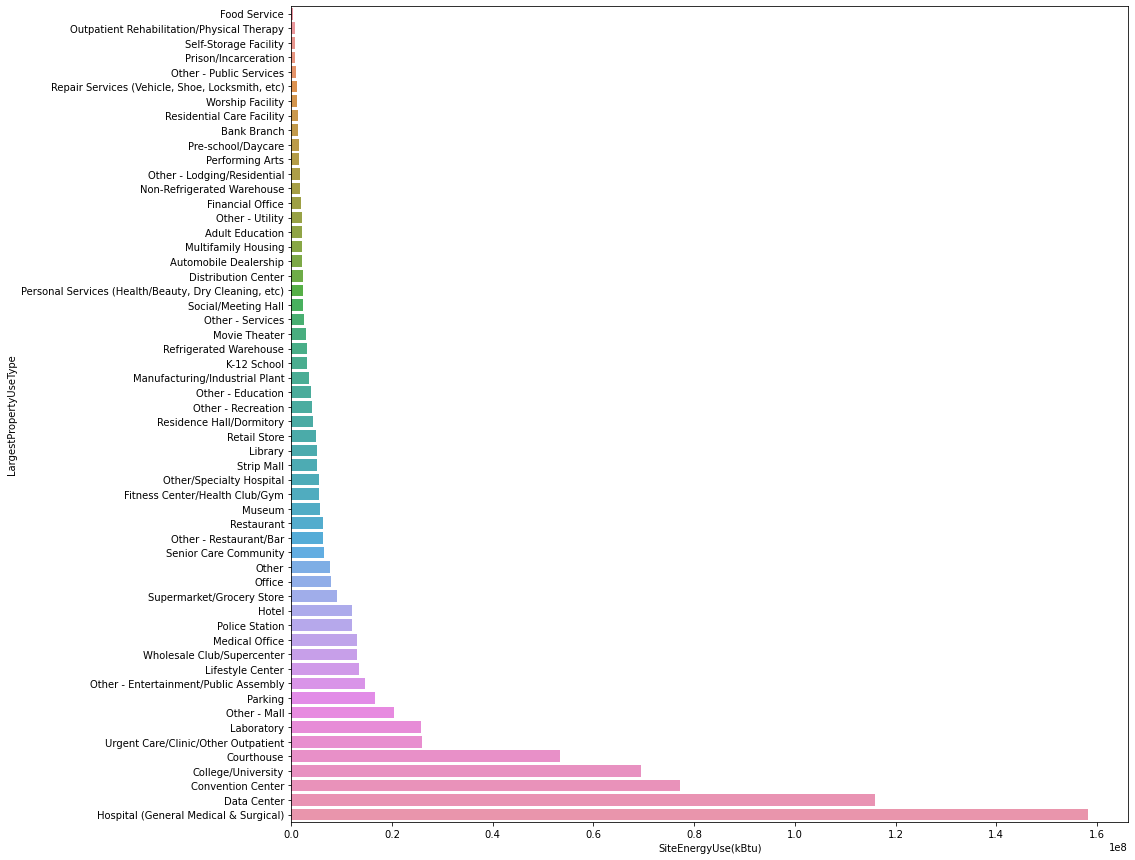

In [19]:
consumption_vs_type(bench,'LargestPropertyUseType')

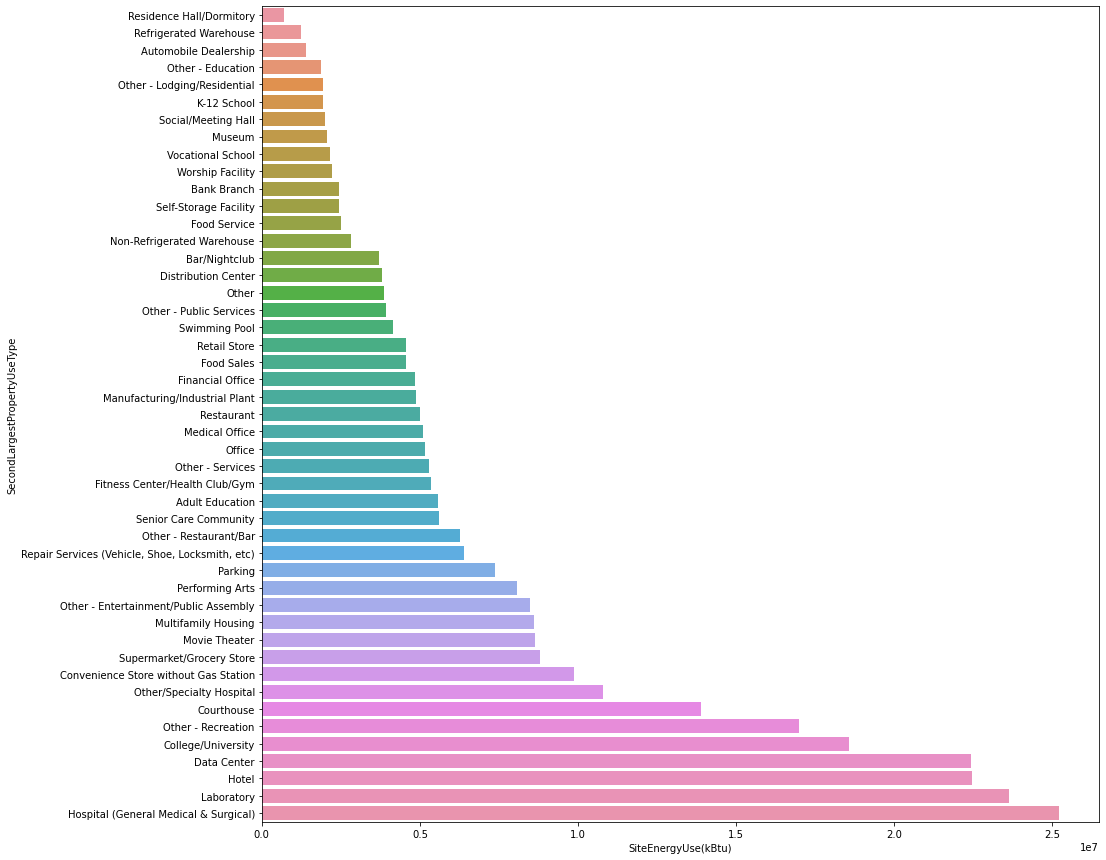

In [20]:
consumption_vs_type(bench15,'SecondLargestPropertyUseType')

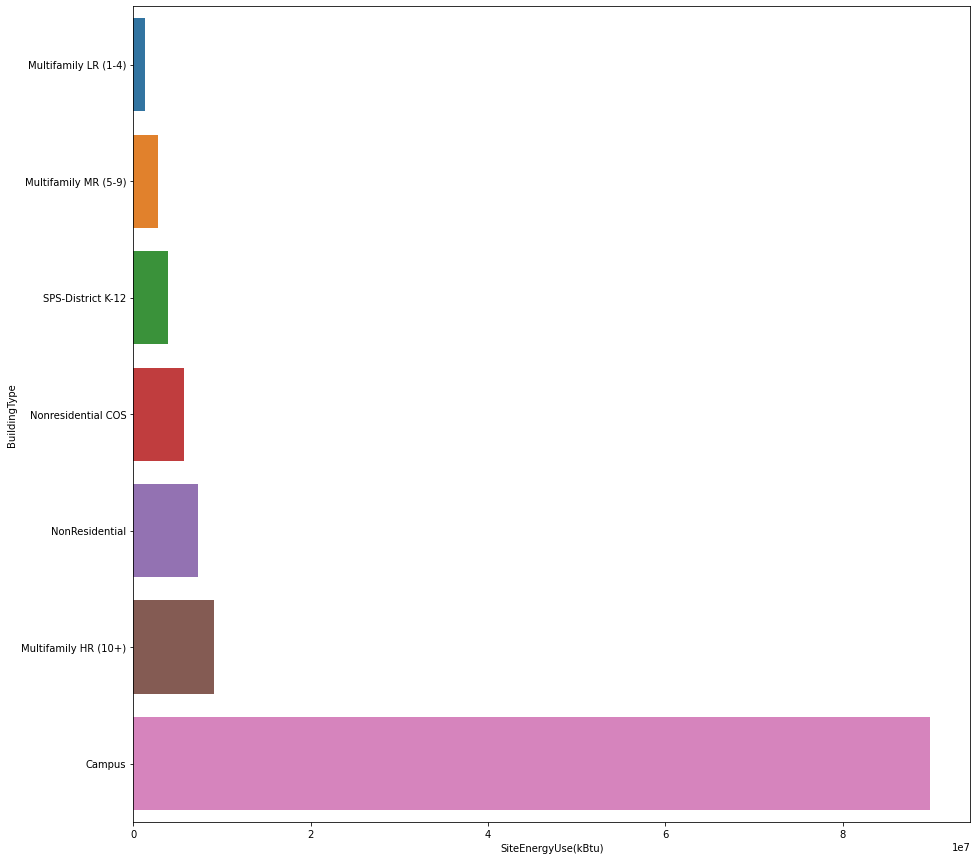

In [21]:
consumption_vs_type(bench,'BuildingType')

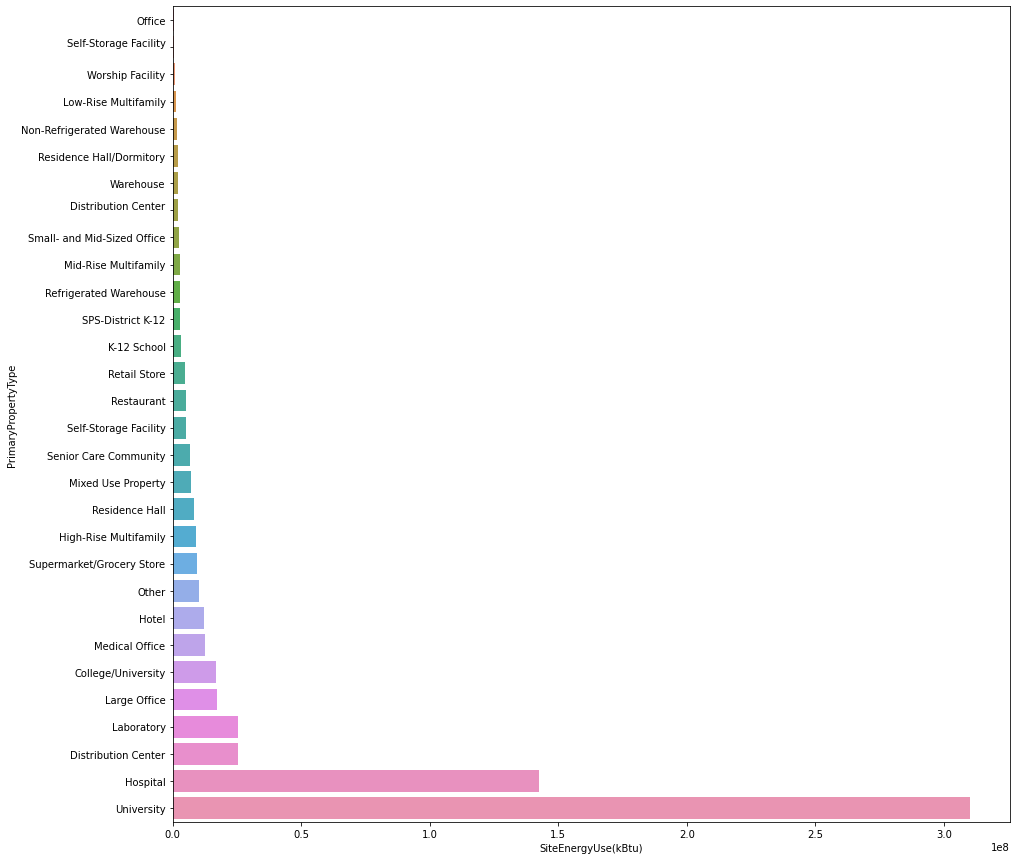

In [22]:
consumption_vs_type(bench,'PrimaryPropertyType')

In [23]:
variables=pd.DataFrame(data=bench.columns,columns=['Variables'])
variables['type']=[variable_type(bench,x) for x in bench.columns]
variables['nb_cat']=[bench[x].value_counts().shape[0]  if x in variables[variables["type"]=="object_categorical"].values else 'irrelevant' for x in variables['Variables']]
variables['graph']=variables['type'].apply(lambda r : graph(r))
variables=variables.set_index('Variables')
# variables

In [24]:
# bench[bench['PrimaryPropertyType'].apply(lambda s:'Rest' in s)]

In [25]:
# variable_exploration(bench,variables,'LargestPropertyUseType')

In [26]:
# variable_exploration(bench,variables,'NumberofBuildings')

In [27]:
# variable_exploration(bench,variables,'Electricity(kWh)')

In [28]:
# variable_exploration(bench,variables,'SiteEnergyUse(kBtu)')

In [29]:
# variable_exploration(bench,variables,"GHGEmissionsIntensity(kgCO2e/ft2)")

In [30]:
# variable_exploration(bench15,variables,"YearBuilt")

In [31]:
# variable_exploration(bench15,variables,"BuildingType")

In [32]:
# variable_exploration(bench15,variables,"PropertyGFATotal")

In [33]:
# bench[bench["PropertyGFATotal"]>8*10**6]

In [80]:
explanatory_variable=['PropertyAge','NumberofBuildings','NumberofFloors','PrimaryPropertyType','PropertyGFATotal','LargestPropertyUseType','LargestPropertyUseTypeGFA',"SecondLargestPropertyUseType","SecondLargestPropertyUseTypeGFA",'ENERGYSTARScore','SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)']
bench_explanatory=bench[explanatory_variable]

In [81]:
bench_explanatory = bench_explanatory.dropna(subset=['ENERGYSTARScore'])

In [77]:
bench_explanatory = bench_explanatory.drop(columns=['ENERGYSTARScore'])

In [82]:
bench_explanatory.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2379 entries, 0 to 3107
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PropertyAge                      2379 non-null   int64  
 1   NumberofBuildings                2379 non-null   Int64  
 2   NumberofFloors                   2379 non-null   Int64  
 3   PrimaryPropertyType              2379 non-null   object 
 4   PropertyGFATotal                 2379 non-null   int64  
 5   LargestPropertyUseType           2379 non-null   object 
 6   LargestPropertyUseTypeGFA        2379 non-null   float64
 7   SecondLargestPropertyUseType     2379 non-null   object 
 8   SecondLargestPropertyUseTypeGFA  2379 non-null   float64
 9   ENERGYSTARScore                  2379 non-null   float64
 10  SiteEnergyUse(kBtu)              2379 non-null   float64
 11  GHGEmissions(MetricTonsCO2e)     2379 non-null   float64
dtypes: Int64(2), float64

In [83]:
bench_explanatory.to_excel('benchmark_cleaned_4.xlsx',index=False)